https://www.ocf.berkeley.edu/~mathiasgibson/2017/12/05/vacant-parcels-in-oakland-ca/

## Import and Load Packages

In [3]:
#Data, Plotting, Mapping
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import fiona #read_file uses Fiona to handle the actual reading and writing of files (can handle Shapefiles and GeoJSON formatted files)
pylab.rcParams['figure.figsize'] = 10, 8

#APIs
import json      # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
import pprint    # library for cleanly printing Python data structures
pp = pprint.PrettyPrinter()

import warnings 
warnings.filterwarnings('ignore')

## Clean and Merge Parcel and Tax Data

In [6]:
#Loading Polygon Shapefile
parcels = gpd.read_file('Alameda County Parcel Boundaries/geo_export_a85caf8b-4f4f-46a5-be18-af34498f0784.shp')
parcels_clean = parcels.drop(['page','book','editor','clca_categ','fid_parcel'], axis=1)
#print(type(parcels))
#print(parcels.head())

In [7]:
#load and drop fields from tax roll file
tax = pd.read_csv('Assessor_s_Office_Secured_Tax_Roll_-_2017_2018.csv')
tax['Year'] = tax['Latest Document Date'].str[6:10].fillna(0).astype('int')
tax_clean = tax.drop(['Situs Unit','TRA Primary','TRA Secondary','CLCA Land','Fixtures','Latest Document Prefix','BPP','HPP','CLCA Imps','Source','HOEX','OTEX','Print Parcel','Situs Zip + 4', 'Mailing Address Street','Mailing Address Unit','Mailing Address City State','Mailing Address Zip','Mailing Address Zip + 4','CKDIGIT','WSEQ','Mailing Address Effective Date','Econ Unit','Latest Document Input Date','Delete Date'], axis=1)

In [ ]:
#clean commas and make int for calculations
tax_clean['Use Code']= tax_clean['Use Code'].str.replace(',', '')
tax_clean['Use Code']= tax_clean['Use Code'].astype('int')

tax_clean['Land']= tax_clean['Land'].str.replace(',', '')
tax_clean['Land'] = tax_clean['Land'].astype('int')

tax_clean['Imps']= tax_clean['Imps'].str.replace(',', '')
tax_clean['Imps'] = tax_clean['Imps'].astype('int')

tax_clean['Total Net Value']= tax_clean['Total Net Value'].str.replace(',', '')
tax_clean['Total Net Value'] = tax_clean['Total Net Value'].astype('int')

tax_clean['Situs Street Number'] = tax_clean['Situs Street Number'].astype('str')
tax_clean['Situs Street Number'] = tax_clean['Situs Street Number'].str.replace(',', '')

tax_clean['Latest Document Series']= tax_clean['Latest Document Series'].astype('str')
tax_clean['Latest Document Series']= tax_clean['Latest Document Series'].str.replace(',', '')

tax_clean['Latest Document Prefix']= tax_clean['Latest Document Prefix'].astype('str')
tax_clean['Latest Document Prefix']= tax_clean['Latest Document Prefix'].str.replace(',', '')

In [15]:
tax_clean.head()

,Sort Parcel,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code
0,051 481603000,142,SANDRINGHAM RD,PIEDMONT,94611,520200,1213800,1727000,2016,157856,06/23/2016 12:00:00 AM,1100
1,051 481603100,136,SANDRINGHAM RD,PIEDMONT,94611,239439,558691,791130,1999,39179,01/29/1999 12:00:00 AM,1100
2,051 481603200,130,SANDRINGHAM RD,PIEDMONT,94611,665645,1647173,2305818,2012,213397,07/03/2012 12:00:00 AM,1100
3,051 481603300,120,SANDRINGHAM RD,PIEDMONT,94611,481817,249205,724022,2013,136132,04/17/2013 12:00:00 AM,1100
4,051 481700101,20,SELBORNE DR,PIEDMONT,94611,642600,1193400,1836000,2016,138794,06/02/2016 12:00:00 AM,1100


In [16]:
tax_parcels = pd.merge(parcels_clean, tax_clean, left_on="apn_sort", right_on="Sort Parcel", how="inner")

oakland_parcels = tax_parcels[tax_parcels['Situs City']=='OAKLAND']

oakland_parcels = oakland_parcels[oakland_parcels['geometry'].notnull()]
#oakland_parcels_clean.shape: 98,460 parcels, lost 300k+ parcels

In [17]:
#dropping extra spatial fields from parcel data
oakland_parcels = oakland_parcels.drop(['shape_st_4','shape_st_1','sub_parcel','date_updat','shape_stle', 'centroid_x', 'shape_star', 'comments', 'shape_st_3','apn', 'shape_st_2', 'centroid_y', 'parcel', 'date_creat', 'Sort Parcel'],1)

In [176]:
oakland_parcels.head()

,apn_sort,geometry,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code
0,048 629806800,POLYGON ((-122.1203618878905 37.75620960906961...,21,MARVIN CT,OAKLAND,94605,99967,118540,211507,"2,015","233,313",08/20/2015 12:00:00 AM,1100
1,048 629800302,POLYGON ((-122.1238375824534 37.75571233182055...,"10,709",COTTER ST,OAKLAND,94605,97680,228104,318784,"2,009","294,376",09/11/2009 12:00:00 AM,1100
2,048 629907100,POLYGON ((-122.1232337216532 37.75211193059634...,"4,734",SHETLAND AVE,OAKLAND,94605,35913,54715,83628,"2,013","311,619",09/19/2013 12:00:00 AM,1100
3,048 631302300,POLYGON ((-122.1250419508898 37.75428601190077...,"4,728",SCOTIA AVE,OAKLAND,94605,79230,80026,152256,"2,013","237,972",07/10/2013 12:00:00 AM,1100
4,048 643203900,POLYGON ((-122.1285286631322 37.76246225016029...,448,ELYSIAN FIELDS DR,OAKLAND,94605,269280,628320,890600,"2,015","285,900",10/23/2015 12:00:00 AM,1100


In [180]:
oakland_parcels.shape

(98460, 13)

## Zoning

In [40]:
zoning = gpd.read_file('City-wide Zoning Map/geo_export_e3412bab-6a4e-42e8-893b-592036e2869f.shp')
zoning.head()

,overlay,ordinance,znlabel,expiredate,perimeter,area,test,lastupdate,effctvdate,basezone,geometry
0,/S-19,12875,CIX-1/S-19,,1015.466097,5.512397e+06,CIX-1/S-19,20090304,20080718,CIX-1,POLYGON ((-122.2857308439033 37.82232725511785...
1,/S-19,12875,CIX-1/S-19,,1015.466097,5.744007e+05,CIX-1/S-19,20090304,20080718,CIX-1,POLYGON ((-122.2812909540165 37.80236514210691...
2,/S-19,12875,CIX-1/S-19,,17791.906465,3.983032e+06,CIX-1/S-19,20090304,20080718,CIX-1,(POLYGON ((-122.2993166973065 37.8062938028413...
3,,,OS (NP),,1498.555904,1.389631e+05,OS (NP),20090304,,OS (NP),POLYGON ((-122.1773177128875 37.72609018686309...
4,,,R-40,,2286.429366,1.662382e+05,R-40,20090304,,R-40,POLYGON ((-122.1824047150539 37.72864462309264...


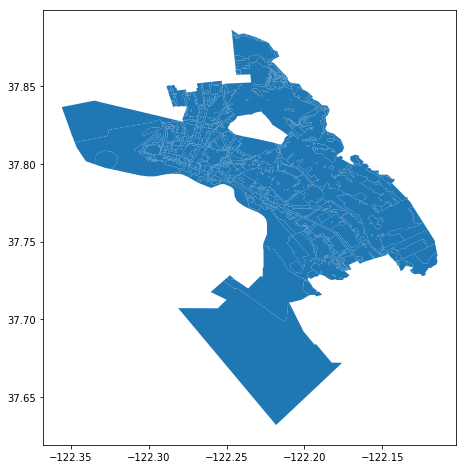

In [59]:
zoning.plot()

In [41]:
zoning_clean = zoning[zoning['geometry'].notnull()]
#zoning_clean.shape: 993 zones, lost 52 zones


In [42]:
zoning_clean = zoning_clean.drop(['overlay', 'ordinance', 'znlabel', 'expiredate', 'perimeter', 'area', 'test', 'lastupdate', 'effctvdate'],1)

In [45]:
oakland_parcels_zone = gpd.sjoin(oakland_parcels,zoning_clean, how="inner", op='intersects')
oakland_parcels_zone.head()

,apn_sort,geometry,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code,index_right,basezone
0,048 629806800,POLYGON ((-122.1203618878905 37.75620960906961...,21,MARVIN CT,OAKLAND,94605,99967,118540,211507,2015,233313,08/20/2015 12:00:00 AM,1100,130,R-30
1,048 629800302,POLYGON ((-122.1238375824534 37.75571233182055...,10709,COTTER ST,OAKLAND,94605,97680,228104,318784,2009,294376,09/11/2009 12:00:00 AM,1100,130,R-30
2,048 629907100,POLYGON ((-122.1232337216532 37.75211193059634...,4734,SHETLAND AVE,OAKLAND,94605,35913,54715,83628,2013,311619,09/19/2013 12:00:00 AM,1100,130,R-30
3,048 631302300,POLYGON ((-122.1250419508898 37.75428601190077...,4728,SCOTIA AVE,OAKLAND,94605,79230,80026,152256,2013,237972,07/10/2013 12:00:00 AM,1100,130,R-30
6,048 643100700,POLYGON ((-122.1316070320111 37.76050218325625...,95,DONNA WAY,OAKLAND,94605,105246,209090,307336,2005,227583,06/06/2005 12:00:00 AM,1100,130,R-30


## Vacancy

#### Vacant Use Codes
800: Vacant residential tract lot  
1000: Vacant residential land, zoned 4 units or less  
1040: Vacant residential land, R&T 402.1  
3000: Vacant commercial land (may include misc. imps)  
4000: Vacant industrial land (may include misc. imps)  
5000: Vacant rural-res homesites, may incl misc. imps  
5700: Vacant rural land, not usable even for agriculture  
5900: Vacant rural land, non-renewal Williamson Act  
6000: Vacant land necessary part of institutional prop.  
6001: Government owned property - vacant land  
7000: Vacant apartment land, capable of 5 or more units  
7040: Vacant apartment land, R&T 402.1  
7090: Vacant apartment common area or use

In [51]:
##filtering oakland_parcels_zone to use codes with "vacant" in description, 4992 parcels
vacant_parcels_zone = oakland_parcels_zone[oakland_parcels_zone['Use Code'].isin(['800', '1000', '1040', '3000', '4000', '5000','5700', '5900', '6000', '6001', '7000', '7040', '7090'])]

In [64]:
#drop duplicate parcels created in match of zone and parcels, down to 4120 parcels
vacant_parcels_zone = vacant_parcels_zone.drop_duplicates(subset='apn_sort')

In [130]:
#filtering oakland_parcels to use codes with "vacant" in description, 4141 parcels
vacant_parcels = oakland_parcels[oakland_parcels['Use Code'].isin(['800', '1000', '1040', '3000', '4000', '5000','5700', '5900', '6000', '6001', '7000', '7040', '7090'])]

In [308]:
#projecting to MTC standard (Universal Transverse Mercator (UTM), Zone 10N, NAD83)
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
crs_4326 = {'init' :'epsg:4326'}

vacant_parcels_proj = vacant_parcels.to_crs(mtc_crs)

In [443]:
#add parcel area in square feet
vacant_parcels_proj['Parcel Area'] = round(vacant_parcels_proj.area*10.7639,0).astype('int')

In [444]:
vacant_parcels_proj['Value per SQFT'] = round(vacant_parcels_proj['Total Net Value']/vacant_parcels_proj['Parcel Area'],2).astype('int')

In [316]:
#pull year from data
vacant_parcels_proj['Year'] = vacant_parcels_proj['Latest Document Date'].str[6:10].fillna(0).astype('int')

In [ ]:
#add continuous variable for time that inludes day and month fractions
vacant_parcels_proj['Timeline'] = ((vacant_parcels_proj['Latest Document Date'].str.split('/').str[0].fillna(0).astype('int'))/12) + ((vacant_parcels_proj['Latest Document Date'].fillna(0).str.split('/').str[1].fillna(0).astype('int'))/365) + vacant_parcels_proj['Latest Document Date'].str.split('/').str[2].str[:4].fillna(0).astype('int')

In [322]:
#add vacant land tax
vacant_parcels_proj['Tax'] = (vacant_parcels_proj['Total Net Value']/100)*5

In [ ]:
#adding concatenated address field
vacant_parcels_point['address'] = vacant_parcels_point['Situs Street Number'] + ' ' + vacant_parcels_point['Situs Street Name'] + ',' + vacant_parcels_point['Situs Zip'] 

In [323]:
vacant_parcels_proj.head()

,apn_sort,geometry,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code,Parcel Area,Value per SQFT,Year,Tax
index_right,,,,,,,,,,,,,,,,,
12,048 622603302,"POLYGON ((576875.4203353269 4178708.951900872,...",10838,MONAN ST,OAKLAND,94603,14032,0,14032,1997,145142,06/12/1997 12:00:00 AM,1000,6324.0,2.22,1997,701.60
67,048 622603400,"POLYGON ((576846.6307726398 4178727.949992827,...",10830,MONAN ST,OAKLAND,94603,14032,0,14032,1997,145142,06/12/1997 12:00:00 AM,1000,5966.0,2.35,1997,701.60
102,048 622603101,"POLYGON ((576870.9591329744 4178685.211316607,...",nan,MONAN ST,OAKLAND,94603,14032,0,14032,1997,145142,06/12/1997 12:00:00 AM,1000,5161.0,2.72,1997,701.60
113,048 633000704,"POLYGON ((577363.9377534282 4178597.649142545,...",nan,GRASS VALLEY RD,OAKLAND,94603,81443,0,81443,2006,135203,04/06/2006 12:00:00 AM,1000,20065.0,4.06,2006,4072.15
131,048 622900200,"POLYGON ((576753.4359862545 4178862.745037626,...",nan,MONAN ST,OAKLAND,94603,22274,0,22274,2001,382779,10/08/2001 12:00:00 AM,1000,7293.0,3.05,2001,1113.70


In [134]:
#exporting to shapefile
vacant_parcels_proj.to_file('data/vacant_parcels_proj.shp')

#exporting to geojson
#with open('data/vacant_parcels_proj.geojson', 'w') as f:
#    f.write(vacant_parcels_proj.to_json())

#export to csv
#vacant_parcels_proj.to_csv('data/vacant_parcels.csv')

## Clean and Load Census Data

In [ ]:
#census API data
endpoint_url = "https://api.census.gov/data/2015/acs/acs5/subject?get=S1903_C02_001E,S1101_C01_009E&for=tract:*&in=state:06%20county:001&key=716a1bb1957c238ee8cedf7262e227a3a3220d32"
response = requests.get(endpoint_url)
results = response.text

data = json.loads(results)
print(type(data))
pp.pprint(data)

In [ ]:
#put data into dataframe, rename columns and get rid of first row headers
census = pd.DataFrame.from_records(data)
census.columns = ["income","households","state","county","tract"]
census = census.iloc[1:]
census = census.drop(['state','county'], axis=1).reset_index()
census = census.drop(['index'], axis = 1)
census.head()

In [ ]:
#convert str to int for calculations
census['households'] = census['households'].astype('int')
census['income'] = census['income'].astype('int')

## Tracts

In [18]:
#load Alameda County census tract shapefile
tracts = gpd.read_file('Alameda County US Census Tracts 2010/geo_export_90da157e-1183-4f96-ae48-e70be0e65a06.shp')

In [19]:
#drop unwanted fields
tracts = tracts.drop(['funcstat10', 'geoid10', 'countyfp10', 'namelsad10', 'awater10', 'statefp10', 'intptlat10', 'intptlon10', 'aland10', 'mtfcc10', 'name10'],1)

In [301]:
#load oakland city limits
citylimits = gpd.read_file('City of Oakland City Limits/geo_export_d9d8cc59-2c85-415c-bc13-d26992faaab8.shp')

In [21]:
#get tracts for oakland
oakland_tracts = gpd.sjoin(tracts, citylimits, how="inner", op='intersects')
oakland_tracts = oakland_tracts.drop(['index_right','shape_area', 'shape_leng', 'name', 'objectid_1', 'shape_le_1', 'id','objectid'],1)

In [81]:
#get rid of tract 990000 since it has no housholds
oakland_tracts = oakland_tracts[oakland_tracts['tractce10'] != '990000']

In [91]:
#merge with census data
oakland_census = pd.merge(oakland_tracts, census, left_on="tractce10", right_on="tract", how="inner")

In [294]:
#project to MTC CRS
oakland_census = oakland_census.to_crs(mtc_crs)

In [155]:
oakland_census

,tractce10,geometry,income,households,tract
0,405800,POLYGON ((-122.2284180000002 37.79137600000006...,43278,1365,405800
1,432200,POLYGON ((-122.1612980000002 37.73726900000005...,61094,1666,432200
2,402900,POLYGON ((-122.2654490000002 37.80633800000005...,31319,851,402900
3,407300,POLYGON ((-122.2033600000002 37.76243500000005...,51042,720,407300
4,423800,POLYGON ((-122.2419250000002 37.85201700000005...,135278,1300,423800


In [453]:
parcels_tracts = gpd.sjoin(oakland_census, vacant_parcels_proj, how="inner", op='intersects')

In [454]:
parcels_tracts.head()

,tractce10,geometry,income,households,tract,index_right,apn_sort,Situs Street Number,Situs Street Name,Situs City,...,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code,Parcel Area,Value per SQFT,Year,Tax,Timeline
0,405800,"POLYGON ((567934.8151053375 4182948.480363757,...",43278,1365,405800,93260,022 032300900,1400,E 23RD ST,OAKLAND,...,52812,2014,136870,06/06/2014 12:00:00 AM,1000,3148,16,2014,2640.60,2014.516438
0,405800,"POLYGON ((567934.8151053375 4182948.480363757,...",43278,1365,405800,193208,022 032301100,1400,E 23RD ST,OAKLAND,...,52812,2014,136870,06/06/2014 12:00:00 AM,1000,3148,16,2014,2640.60,2014.516438
0,405800,"POLYGON ((567934.8151053375 4182948.480363757,...",43278,1365,405800,85466,022 035301704,nan,WALLACE ST,OAKLAND,...,60049,2008,195307,06/20/2008 12:00:00 AM,1000,5324,11,2008,3002.45,2008.554795
0,405800,"POLYGON ((567934.8151053375 4182948.480363757,...",43278,1365,405800,393009,022 034702100,2530,14TH AVE,OAKLAND,...,30899,nan,0,NaN,1000,2595,11,0,1544.95,0.000000
0,405800,"POLYGON ((567934.8151053375 4182948.480363757,...",43278,1365,405800,393008,022 034702000,2530,14TH AVE,OAKLAND,...,31362,nan,0,NaN,1000,2635,11,0,1568.10,0.000000


In [296]:
parcels_tracts.to_file('data/parcels_tracts.shp')

In [93]:
#file was too big, trimming geo and re-merging with original tracts to cut excess weight from sjoin
oakland_census2 = oakland_census.drop(['geometry'],1)

In [94]:
census_tracts2 = pd.merge(tracts, oakland_census2, on="tractce10", how="inner")

In [92]:
census_tracts2.head()

,tractce10,geometry,income,households,tract
0,405800,POLYGON ((-122.2284180000002 37.79137600000006...,43278,1365,405800
1,432200,POLYGON ((-122.1612980000002 37.73726900000005...,61094,1666,432200
2,402900,POLYGON ((-122.2654490000002 37.80633800000005...,31319,851,402900
3,407300,POLYGON ((-122.2033600000002 37.76243500000005...,51042,720,407300
4,423800,POLYGON ((-122.2419250000002 37.85201700000005...,135278,1300,423800


In [31]:
#projecting to mtc crs
census_tracts_proj = census_tracts.to_crs(mtc_crs)

In [95]:
#export to shapefile
census_tracts2.to_file('data/census_tracts2.shp')

#export to csv
#census_tracts_proj.to_csv('data/census_tracts.csv')

## Point Data

In [ ]:
#getting point data for parcels
vacant_parcels_proj['point']=vacant_parcels_proj['geometry'].centroid
vacant_parcels_proj['geometry'] = vacant_parcels_proj['Point']
vacant_parcels_point = vacant_parcels_proj.drop(['Point','point'],1)
vacant_parcels_point.head()

In [306]:
vacant_parcels_point.head()

,apn_sort,geometry,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code,address
index_right,,,,,,,,,,,,,,
12,048 622603302,POINT (576855.1953834846 4178702.69939271),10838,MONAN ST,OAKLAND,94603,14032,0,14032,1997,145142,06/12/1997 12:00:00 AM,1000,10838 MONAN ST
67,048 622603400,POINT (576858.2631909454 4178718.904293639),10830,MONAN ST,OAKLAND,94603,14032,0,14032,1997,145142,06/12/1997 12:00:00 AM,1000,10830 MONAN ST
102,048 622603101,POINT (576851.9911700762 4178673.159964592),nan,MONAN ST,OAKLAND,94603,14032,0,14032,1997,145142,06/12/1997 12:00:00 AM,1000,nan MONAN ST
113,048 633000704,POINT (577336.1958273546 4178611.179927636),nan,GRASS VALLEY RD,OAKLAND,94603,81443,0,81443,2006,135203,04/06/2006 12:00:00 AM,1000,nan GRASS VALLEY RD
131,048 622900200,POINT (576731.1352867181 4178858.474991242),nan,MONAN ST,OAKLAND,94603,22274,0,22274,2001,382779,10/08/2001 12:00:00 AM,1000,nan MONAN ST


In [109]:
vacant_parcels_point.to_file('data/vacant_parcels_point.shp')

In [309]:
#grab lat(y)/lon(x) from centroid point data (just in case I need it)
vacant_parcels_point['lon'] = vacant_parcels_point.to_crs(crs_4326).geometry.centroid.x
vacant_parcels_point['lat'] = vacant_parcels_point.to_crs(crs_4326).geometry.centroid.y

#### BART

In [468]:
#load bart and change crs
bart = gpd.read_file('BART_Sta_13/BART_Sta_13.shp').to_crs(crs_4326)

In [472]:
#merge with Oakland shapefile to filter out non-oakland stops
oakland_bart = gpd.sjoin(bart, citylimits, how="inner", op='intersects').to_crs(mtc_crs)

In [474]:
#calculate minimum distance to bart
vacant_parcels_proj['bart_distance'] = vacant_parcels_proj.geometry.apply(lambda g: bart_oakland.distance(g).min())


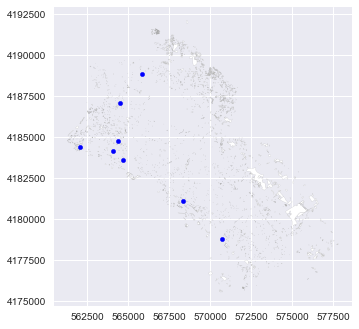

In [476]:
#plot to verify that all the stations made it
base = vacant_parcels_proj.plot(color='white', edgecolor='gray', linewidth=.1)
oakland_bart.plot(ax=base, color='blue', markersize = 20);

In [492]:
#generate 1/2 mile buffer
bart_buffer = oakland_bart['geometry'].buffer(805)

In [493]:
bart_buffer = gpd.GeoDataFrame({'geometry': bart_buffer})

In [549]:
parcels_bart = gpd.sjoin(bart_buffer, vacant_parcels_point, how="inner", op='intersects')

In [550]:
parcels_bart.shape

(598, 16)

#### Schools

In [510]:
#loading schools and splitting lat and long into separate columns
schools = pd.read_csv('Map_of_Oakland_Public_Schools.csv')
schools['LATITUDE'] = schools['ADDRESS'].str.split('\n').str[2].str.split(',').str[0].str[1:].astype('float')
schools['LONGITUDE'] = schools['ADDRESS'].str.split('\n').str[2].str.split(',').str[1].str[:-1].astype('float')

In [558]:
#geocoding schools as point data
geometry = [Point(xy) for xy in zip(schools.LONGITUDE, schools.LATITUDE)]
geoschools = GeoDataFrame(schools, crs=mtc_crs, geometry=geometry)
geoschools = geoschools.drop(['PHONE'],1)
geoschools.head()

,TYPE,SCHOOL,ADDRESS,LATITUDE,LONGITUDE,geometry
index_right,,,,,,
0,Charter,CONSERVATORY OF INSTRUMENTAL AND VOCAL ARTS (C...,"3800 Mountain Blvd.\nOakland, CA\n(37.79885815...",37.798858,-122.184874,POINT (-122.1848741187958 37.79885815810979)
1,Charter,ARISE HIGH SCHOOL,"3301 E. 12th Street, Suite 205\nOakland, CA\n(...",37.776168,-122.224984,POINT (-122.2249838813026 37.77616826331058)
2,Middle,ALLIANCE ACADEMY,"1800 98th Ave\nOakland, CA\n(37.74664352108863...",37.746644,-122.165602,POINT (-122.165601647708 37.74664352108863)
3,High,BUNCHE ACADEMY,"1240 18th St\nOakland, CA\n(37.813003268562255...",37.813003,-122.286891,POINT (-122.2868910674102 37.81300326856226)
4,Elementary,INTERNATIONAL COMM. ELEMENTARY,"2825 International Blvd\nOakland, CA\n(37.7798...",37.779820,-122.230011,POINT (-122.2300110914464 37.77981951074952)


#### Parks

In [261]:
#loading parks and splitting lat and long into separate columns
parks = pd.read_csv('Map_of_Parks_and_Recreation_Facilities.csv')
parks['Latitude'] = parks['Location 1'].str.split('\n').str[2].str.split(',').str[0].str[1:].astype('float')
parks['Longitude'] = parks['Location 1'].str.split('\n').str[2].str.split(',').str[1].str[0:-1].astype('float')
parks = parks.drop(['Phone Number','URL','Location 1'],1)
parks.head()

,Parks and Recreation Facilities,Facility Type,Latitude,Longitude
0,Lake Merritt Sail Boat House,Rental Facility,37.806761,-122.256625
1,Brookdale,Tennis Court,37.805060,-122.273020
2,Allendale Park,Park,37.789919,-122.202924
3,Park Blvd Plaza Park,Park,37.800631,-122.247661
4,Rainbow,Recreation Center,37.765493,-122.200297


In [198]:
#geocoding parks as point data
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(parks.Longitude, parks.Latitude)]
geoparks = GeoDataFrame(parks, crs=crs, geometry=geometry)
geoparks.head()

,Parks and Recreation Facilities,Facility Type,geometry
0,Lake Merritt Sail Boat House,Rental Facility,POINT (-122.2566247980454 37.80676133380701)
1,Brookdale,Tennis Court,POINT (-122.2730199996731 37.80505999961946)
2,Allendale Park,Park,POINT (-122.2029235119239 37.78991889713853)
3,Park Blvd Plaza Park,Park,POINT (-122.2476606965575 37.80063109648487)
4,Rainbow,Recreation Center,POINT (-122.2002974915983 37.76549331082276)


## Calculations and Charts

In [430]:
import seaborn as sns
sns.set(color_codes=True)
from scipy.stats import norm

import statsmodels.api as sm
import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab

In [ ]:
#filter timeline to remove and value to exclude extreme outliers
year_clean = vacant_parcels_proj[(vacant_parcels_proj['Timeline'] > 1950) & (vacant_parcels_proj['Value per SQFT'] > 50)]

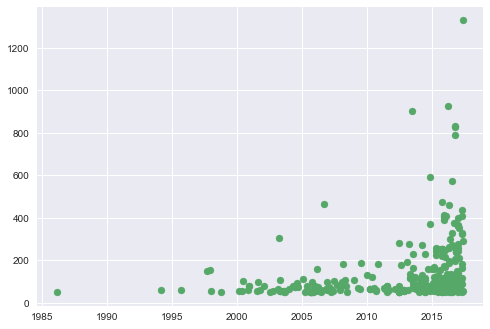

In [431]:
#run regression and plot relationship of time of appraisal on sqft value 
plt.scatter(year_clean['Timeline'], year_clean['Value per SQFT'], c='g')

In [433]:
X = sm.add_constant(year_clean['Timeline'])
model = sm.OLS(year_clean['Value per SQFT'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Value per SQFT   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     26.33
Date:                Mon, 11 Dec 2017   Prob (F-statistic):           4.79e-07
Time:                        13:36:14   Log-Likelihood:                -2222.4
No. Observations:                 349   AIC:                             4449.
Df Residuals:                     347   BIC:                             4456.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.492e+04   2934.107     -5.085      0.0

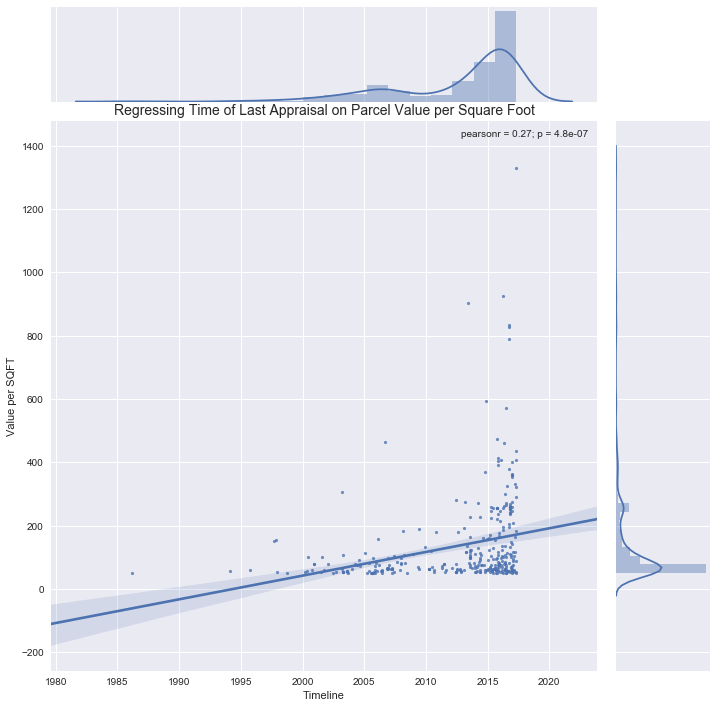

In [566]:
sns.jointplot("Timeline", 'Value per SQFT', data=year_clean, kind="reg", scatter_kws={"s": 10}, size=10)
sns.despine()
plt.title('Regressing Time of Last Appraisal on Parcel Value per Square Foot', fontsize=14)
plt.savefig('data/time_valuesqftreg.png', bbox_inches='tight')

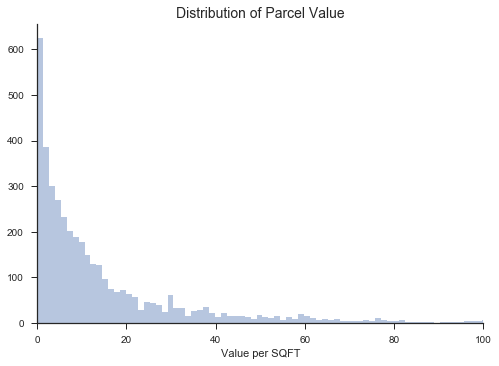

In [364]:
sns.distplot(vacant_parcels_proj['Value per SQFT'], bins=1000, kde=False);
sns.despine()
plt.title('Distribution of Parcel Value', fontsize=14)
plt.xlim(0,100)
plt.savefig('data/dist_valuesqft.png', bbox_inches='tight')

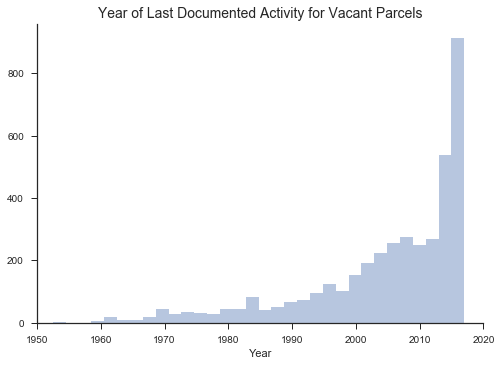

In [362]:
sns.distplot(vacant_parcels_proj['Year'], bins=1000, kde=False);
sns.set_style("ticks")
sns.despine()
plt.title('Year of Last Documented Activity for Vacant Parcels', fontsize=14)
plt.xlim(1950,2020)
plt.savefig('data/dist_year.png', bbox_inches='tight')

In [208]:
code_parcels = vacant_parcels_proj.groupby(['Use Code'])[['apn_sort']].count().reset_index()
code_parcels

,Use Code,apn_sort
0,1000,2997
1,3000,413
2,4000,435
3,5000,4
4,6000,1
5,6001,9
6,7000,243
7,7040,3
8,7090,1
9,800,36


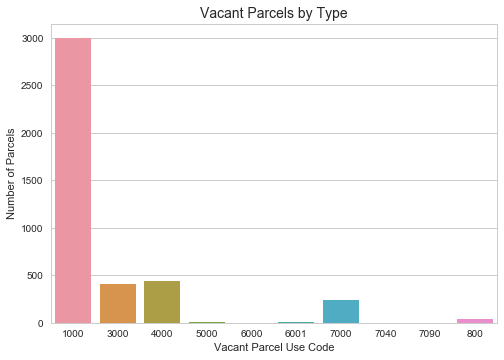

In [227]:
sns.set_style("whitegrid")
sns.barplot(x="Use Code", y="apn_sort", data=code_parcels)
plt.title('Count of Vacant Parcels by Type', fontsize=14)
plt.xlabel('Vacant Parcel Use Code')
plt.ylabel('Number of Parcels')
plt.savefig('data/code_parcels.png', bbox_inches='tight')

In [ ]:
zip_values = vacant_parcels_proj.groupby(['Situs Zip'])[['Total Net Value']].sum().reset_index()
zip_values

In [223]:
code_values = vacant_parcels_proj.groupby(['Use Code'])[['Total Net Value']].sum().reset_index()
code_values

,Use Code,Total Net Value
0,1000,299327689
1,3000,139527984
2,4000,97711261
3,5000,178968
4,6000,0
5,6001,229043
6,7000,450626036
7,7040,804723
8,7090,0
9,800,82213758


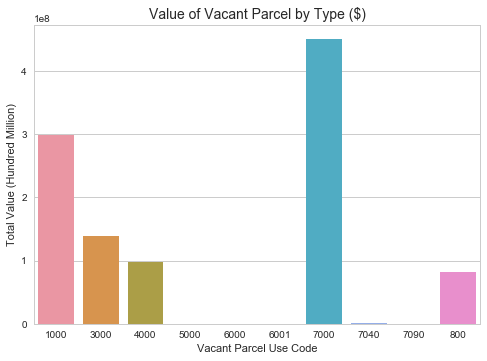

In [242]:
sns.barplot(x="Use Code", y="Total Net Value", data=code_values)
plt.title('Value of Vacant Parcel by Type ($)', fontsize=14)
plt.xlabel('Vacant Parcel Use Code')
plt.ylabel('Total Value (Hundred Million)')
plt.savefig('data/code_values.png', bbox_inches='tight')

In [344]:
code_sqftvalue = vacant_parcels_proj.groupby(['Use Code'])[['Value per SQFT']].median().reset_index()
code_sqftvalue

,Use Code,Value per SQFT
0,1000,6.390
1,3000,17.400
2,4000,10.110
3,5000,0.315
4,6000,0.000
5,6001,0.310
6,7000,56.970
7,7040,0.810
8,7090,0.000
9,800,9.785


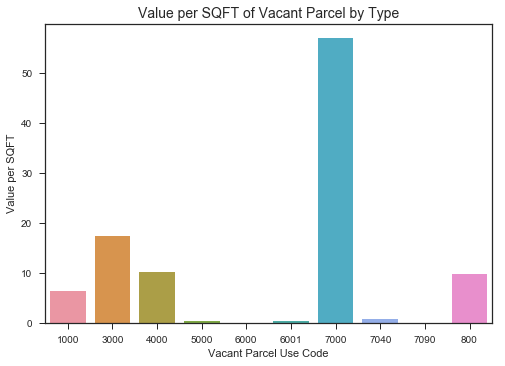

In [345]:
sns.barplot(x="Use Code", y="Value per SQFT", data=code_sqftvalue)
plt.title('Value per SQFT of Vacant Parcel by Type', fontsize=14)
plt.xlabel('Vacant Parcel Use Code')
plt.ylabel('Value per SQFT')
plt.savefig('data/code_sqftvalue.png', bbox_inches='tight')

In [343]:
code_area = vacant_parcels_proj.groupby(['Use Code'])[['Parcel Area']].sum().reset_index()
code_area

,Use Code,Parcel Area
0,1000,43209190.0
1,3000,3441124.0
2,4000,6170475.0
3,5000,557921.0
4,6000,8028.0
5,6001,159599.0
6,7000,3920299.0
7,7040,34011.0
8,7090,115204.0
9,800,7274340.0


In [ ]:
sns.barplot(x="Use Code", y="Parcel Area", data=code_area)
plt.title('Area of Vacant Parcel by Type', fontsize=14)
plt.xlabel('Vacant Parcel Use Code')
plt.ylabel('Parcel Area (ten million sqft)')
plt.savefig('data/code_area.png', bbox_inches='tight')
#ax = plt.gca()
#ax.get_yaxis().get_major_formatter().set_useOffset(False)
#ax1.ticklabel_format(axis='y', style='sci', useOffset=False)
#plt.yticks(np.arange(y.min(), y.max(), 0.005))


In [292]:
code_area = round(parcels_tracts.groupby(['Use Code'])[['income']].mean()).reset_index()
code_area

,Use Code,income
0,1000,107394.0
1,3000,48457.0
2,4000,49853.0
3,5000,104460.0
4,6000,86629.0
5,6001,78814.0
6,7000,49365.0
7,7040,43282.0
8,7090,103117.0
9,800,60705.0


In [ ]:
#value by zoning code
zone_values = vacant_parcels_zone.groupby(['basezone'])[['Total Net Value']].count().reset_index()

In [ ]:
zone_code = vacant_parcels_zone.groupby(['basezone'])[['apn_sort']].count().reset_index().sort_values(by='apn_sort',ascending=False)
zone_code

In [79]:
#summary calculations
total_value = vacant_parcels_proj['Total Net Value'].sum()
#1,070,619,462
median_value = vacant_parcels_proj['Total Net Value'].median()
#46,766.5
mean_value = vacant_parcels_proj['Total Net Value'].mean()
#258,478.87

total_land = vacant_parcels_proj['Land'].sum()
#953,303,097
median_land = vacant_parcels_proj['Land'].median()
#47,746.00
mean_land = vacant_parcels_proj['Land'].mean()
#230,155.26

total_imps = vacant_parcels_proj['Imps'].sum()
#127,205,115
median_imps = vacant_parcels_proj['Imps'].median()
#0
mean_imps = vacant_parcels_proj['Imps'].mean()
#30,711

total_area = vacant_parcels_proj['Parcel Area'].sum()
#15,613,832,452,578
median_area = vacant_parcels_proj['Parcel Area'].median()
#1,430,580,226
mean_area = vacant_parcels_proj['Parcel Area'].mean()
#15,666

total_valuesqft = vacant_parcels_proj['Value per SQFT'].sum()
#94,522.24
median_valuesqft = vacant_parcels_proj['Value per SQFT'].median()
#8.35
mean_valuesqft = vacant_parcels_proj['Value per SQFT'].mean()
#22.82

total_valuesqft = vacant_parcels_proj['Tax'].sum()
#53,530,973.10
median_valuesqft = vacant_parcels_proj['Tax'].median()
#2,338.33
mean_valuesqft = vacant_parcels_proj['Tax'].mean()
#12,923.94

15613832452577.998

# Ignore Below (Notes)